In [78]:
import numpy as np
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import os
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import time
import joblib
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Prepare data

In [79]:
def get_files_in_folder(folder):
      # Liste les fichiers dans le dossier spécifié
      files = [folder  + "/" + f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
      return files

In [80]:
def get_coords(point):
  return [point.x, point.y, point.z]

In [81]:
def get_angles(base, finger, hand):
    # Convertir les coordonnées des points en un tableau NumPy pour faciliter les calculs
    points = np.array([[base.x, base.y, base.z]] + [[p.x, p.y, p.z] for p in finger])

    # Initialiser une liste pour stocker les angles
    angles = []

    # Boucler sur les triplets de points
    for i in range(len(points) - 2):
        # Points A, B, C
        A, B, C = points[i], points[i + 1], points[i + 2]

        # Calcul des vecteurs BA et BC
        BA = A - B
        BC = C - B

        # Normalisation des vecteurs
        BA = BA / np.linalg.norm(BA)
        BC = BC / np.linalg.norm(BC)

        # Produit scalaire entre BA et BC
        dot_product = np.dot(BA, BC)

        # Calcul de l'angle en radians
        cos_theta = np.clip(dot_product, -1.0, 1.0)  # S'assurer que cos_theta reste dans [-1, 1]

        # Ajouter l'angle en radians à la liste
        angles.append(np.arccos(cos_theta) / np.pi) # Calcul de l'angle en radian / pi (pour que angle soit dans [0, 1])

        if i != len(points) - 3: # Calculer la rotation entre les plans
          # Points A, B, C, D
          D = points[i + 3]

          # Calcul des vecteurs AB, AC, BC, BD
          AB = B - A
          AC = C - A
          BD = D - B
          CD = D - C

          #  Normalisation des vecteurs
          AB = AB / np.linalg.norm(AB)
          AC = AC / np.linalg.norm(AC)
          BD = BD / np.linalg.norm(BD)
          CD = CD / np.linalg.norm(CD)

          # Calcul des vecteurs normaux au plan ABC  et BCD
          u = np.cross(AB, AC)
          v = np.cross(BD, CD)

          # Calcul de l'angle en radians
          cos_theta = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
          cos_theta = np.clip(cos_theta, -1.0, 1.0)  # S'assurer que cos_theta reste dans [-1, 1]

          # Ajouter l'angle en radians à la liste
          angles.append(np.arccos(cos_theta) / np.pi) # Calcul de l'angle en radian / pi (pour que angle soit dans [0, 1])

    return angles

def signed_distance(point, normal_vector, d, index):
    """
    Calcule la distance signée d'un point par rapport à un plan.
    :param point: Coordonnées du point [X_train_act, y_train_detected, z]
    :param normal_vector: Vecteur normal du plan [a, b, c]
    :param d: Terme constant de l'équation du plan
    :return: Distance signée
    """
    return (np.dot(normal_vector, point) + d) * math.sqrt((index[1].x - index[0].x)**2 + (index[1].y - index[0].y)**2 + (index[1].z - index[0].z)**2) # De la même longueur que la métacarpe de l'index

def projection_point(p1, p2, q):
    """ Calcule la projection du point q sur la droite passant par p1 et p2 """
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(q) - np.array(p2)
    t = np.dot(v1, v2) / np.dot(v1, v1)
    return np.array(p2) + t * v1

In [82]:
def preprocess(detection):
  hand = detection.handedness[0][0].category_name
  base_poignet = detection.hand_landmarks[0][0]
  pouce = detection.hand_landmarks[0][1:5]
  index = detection.hand_landmarks[0][5:9]
  majeur = detection.hand_landmarks[0][9:13]
  annulaire = detection.hand_landmarks[0][13:17]
  auriculaire = detection.hand_landmarks[0][17:21]

  ## Calcul des angles entre les phalages et la rotation
  angles = get_angles(base_poignet, pouce, hand) + get_angles(base_poignet, index, hand) + get_angles(base_poignet, majeur, hand) + get_angles(base_poignet, annulaire, hand) + get_angles(base_poignet, auriculaire, hand)

  ## Ajout de l'orientation de poignet
  hand_without_fingers = np.array([get_coords(base_poignet), get_coords(pouce[0]), get_coords(index[0]), get_coords(majeur[0]), get_coords(annulaire[0]), get_coords(auriculaire[0])])

  # Appliquer la SVD
  U, S, Vt = np.linalg.svd(hand_without_fingers - np.mean(hand_without_fingers, axis=0))

  # Le vecteur normal du plan est donné par la dernière ligne de Vt
  if np.dot(Vt[2], [1, 1, 1]) >= -np.dot(Vt[2], [1, 1, 1]):
    normal_vector = Vt[2]
  else:
    normal_vector = -Vt[2]

  # Si la paume est vers l'avant de l'écran, c'est à dire le point moyen des bout de doigts est dans la même direction que le vecteur normal
  paume_vers_avant = 0
  if signed_distance(np.mean([get_coords(pouce[-1]), get_coords(index[-1]), get_coords(majeur[-1]), get_coords(annulaire[-1]), get_coords(auriculaire[-1])], axis=0), normal_vector, -np.dot(normal_vector, np.mean(hand_without_fingers, axis=0)), index) > 0:
    normal_vector = -normal_vector
    paume_vers_avant = 1

  # Normalisation du vecteur normal
  normal_vector = normal_vector / np.linalg.norm(normal_vector)

  ### L'index et le majeur sont croisés (pour différencier le R du U)

  # Equation du plan moyen
  a, b, c = normal_vector
  d = -np.dot(normal_vector, np.mean(hand_without_fingers, axis=0))

  ## Calcul de la distance signé entre le plan et l'index et le majeur * la distance de la métacarpe de l'index
  majeur_sur_index = signed_distance(get_coords(majeur[-1]), normal_vector, d, index) - signed_distance(get_coords(index[-1]), normal_vector, d, index)

  ## Calcul de la distance entre les points projetés de la dernière phalange de l'index et du majeur sur la droite donnée par les premières phalanges de l'index et du majeur divisé par la distance entre la première distance de l'index et du majeur

  # Projections des derniers points de l'index et du majeur sur la droite
  index_proj = np.array(projection_point(get_coords(index[0]), get_coords(index[1]), get_coords(index[-1])))
  majeur_proj = np.array(projection_point(get_coords(majeur[0]), get_coords(majeur[1]), get_coords(majeur[-1])))

  # Distance entre les projections des derniers points de l'index et du majeur
  distance_proj = np.linalg.norm(index_proj - majeur_proj)

  # Distance entre les premières phalanges de l'index et du majeur
  distance_base = np.linalg.norm(np.array(get_coords(index[0])) - np.array(get_coords(majeur[0])))

  # Calcul final
  ratio = -distance_proj / distance_base

  # Detection de si le pouce est devant l'index (pour le F et le T)
  index_base_proj_ind_aur = projection_point(get_coords(index[0]), get_coords(auriculaire[0]), get_coords(index[0]))
  index_proj_ind_aur = projection_point(get_coords(index[0]), get_coords(auriculaire[0]), get_coords(index[-1]))
  pouce_proj_ind_aur = projection_point(get_coords(index[0]), get_coords(auriculaire[0]), get_coords(pouce[-1]))
  pouce_ind_croise = int(np.linalg.norm(index_base_proj_ind_aur - index_proj_ind_aur) > np.linalg.norm(index_base_proj_ind_aur - pouce_proj_ind_aur)) # 1 si croise, 0 sinon

  ## Calculer l'angle entre l'index et le majeur

  # Convertir les points en numpy arrays

  # Calcul des vecteurs AB et CD
  index_top_bottom = np.array(get_coords(index[-1])) - np.array(get_coords(index[0]))
  majeur_top_bottom = np.array(get_coords(majeur[-1])) - np.array(get_coords(majeur[0]))

  # Produit scalaire des deux vecteurs
  dot_product = np.dot(index_top_bottom, majeur_top_bottom)

  # Cosinus de l'angle
  cos_theta = dot_product / (np.linalg.norm(index_top_bottom) * np.linalg.norm(majeur_top_bottom))

  # Angle en radians
  angle_index_majeur = np.arccos(np.clip(cos_theta, -1.0, 1.0)) / np.pi  # Clip pour éviter les erreurs numériques

  return angles + [paume_vers_avant, majeur_sur_index, ratio, pouce_ind_croise, angle_index_majeur]

In [83]:
# Fonction pour tester les modèles avec GridSearchCV
def test_models_with_grid_search(X_train_act, y_train_detected, X_test_act, y_test_detected, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)):
    param_grids = {
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': range(1, 12),
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski']
            }
        },
        'DecisionTree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'criterion': ['gini', 'entropy', 'log_loss'],
                'splitter': ['best', 'random'],
                'max_depth': [None, 5, 10, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 5]
            }
        },
        'SVC': {
            'model': SVC(),
            'params': {
                'C': [0.01, 0.1, 1, 10, 100],
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'degree': [2, 3, 4],
                'gamma': ['scale', 'auto'],
                'class_weight': [None, 'balanced']
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200, 500],
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 10, 20, 50],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]
            }
        },
        'LogisticRegression': {
            'model': LogisticRegression(max_iter=1000),
            'params': {
                'C': [0.01, 0.1, 1, 10, 100],
                'penalty': ['l2', None],
                'solver': ['lbfgs', 'saga'],
                'class_weight': [None, 'balanced']
            }
        }
    }

    best_model = None
    best_score = 0
    best_test_score = 0
    best_params = None

    for name, config in param_grids.items():
        print(f"\n{name} :")
        grid_search = GridSearchCV(config['model'], config['params'], cv=cv, scoring='accuracy', verbose=1)
        grid_search.fit(X_train_act, y_train_detected)

        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Best cross-validation score for {name}: {grid_search.best_score_}")

        if grid_search.best_score_ >= best_score:
            test_score = grid_search.best_estimator_.score(X_test_act, y_test_detected)
            if grid_search.best_score_ > best_score or test_score > best_test_score:
                best_test_score = test_score
                best_score = grid_search.best_score_
                best_model = grid_search.best_estimator_
                best_params = grid_search.best_params_

    print(f"\nBest model overall: {best_model}")
    print(f"Best score: {best_score}")
    print(f"Best test score: {best_test_score}")
    print(f"Best parameters: {best_params}")

    return best_model

# Fonction pour dessiner la matrice de confusion
def draw_conf_matrix(best_model, X_test, y_test_detected):
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test_detected, y_pred)

    num_classes = len(np.unique(y_test_detected))
    labels = [chr(65 + i) for i in range(num_classes)]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.show()


In [84]:
# STEP 1:  Get files path
train = get_files_in_folder("train")
test = get_files_in_folder("test")

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=1)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3:  Create X_train, X_test, y_train, y_test
X_train =  [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in train]
y_train = [ord(image_path[-5]) - 65  for image_path in train]
X_test =  [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in test]
y_test = [ord(image_path[-5]) - 65  for image_path in test]

# STEP 4: Predict with mediapipe
X_train_detected,  y_train_detected =  [], []
X_test_detected,  y_test_detected =  [], []

for i in range(0, len(X_train)):
    detection = detector.detect(mp.Image(image_format=mp.ImageFormat.SRGB, data=X_train[i]))
    if len(detection.handedness) > 0:
        if detection.handedness[0][0].category_name == "Left":
          for j in range(0, len(detection.hand_landmarks[0])):
            detection.hand_landmarks[0][j].x = 1 - detection.hand_landmarks[0][j].x
        X_train_detected.append(detection)
        y_train_detected.append(y_train[i])

for i in range(0, len(X_test)):
    detection = detector.detect(mp.Image(image_format=mp.ImageFormat.SRGB, data=X_test[i]))
    if len(detection.handedness) > 0:
        if detection.handedness[0][0].category_name == "Left":
          for j in range(0, len(detection.hand_landmarks[0])):
            detection.hand_landmarks[0][j].x = 1 - detection.hand_landmarks[0][j].x
        X_test_detected.append(detection)
        y_test_detected.append(y_test[i])

# STEP 5: preprocess and stardardize data and reverse data for model 1 and 2
X_train_1_preprocessed = [preprocess(detection) for detection in X_train_detected]
X_test_1_preprocessed = [preprocess(detection) for detection in X_test_detected]

scaler_1  = StandardScaler()
scaler_1.fit(X_train_1_preprocessed)

X_train_1 = scaler_1.transform(X_train_1_preprocessed)
X_test_1 = scaler_1.transform(X_test_1_preprocessed)

X_train_2_preprocessed = [np.array([[lm.x, lm.y, lm.z] for lm in detection.hand_landmarks[0]]).flatten() for detection in X_train_detected]
X_test_2_preprocessed = [np.array([[lm.x, lm.y, lm.z] for lm in detection.hand_landmarks[0]]).flatten() for detection in X_test_detected]

scaler_2  = StandardScaler()
scaler_2.fit(X_train_2_preprocessed)

X_train_2 = scaler_2.transform(X_train_2_preprocessed)
X_test_2 = scaler_2.transform(X_test_2_preprocessed)


# First approch

In [85]:
best_model_1 = test_models_with_grid_search(X_train_1, y_train_detected, X_test_1, y_test_detected)


KNN :
Fitting 5 folds for each of 66 candidates, totalling 330 fits
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best cross-validation score for KNN: 0.7932914046121594

DecisionTree :
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for DecisionTree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation score for DecisionTree: 0.6612858141160027

SVC :
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters for SVC: {'C': 0.1, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score for SVC: 0.7893081761006291

RandomForest :
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters for RandomForest: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-valida

c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty

Best parameters for LogisticRegression: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score for LogisticRegression: 0.7967155835080364

Best model overall: RandomForestClassifier(n_estimators=500, random_state=42)
Best score: 0.8531795946890288
Best test score: 0.9
Best parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


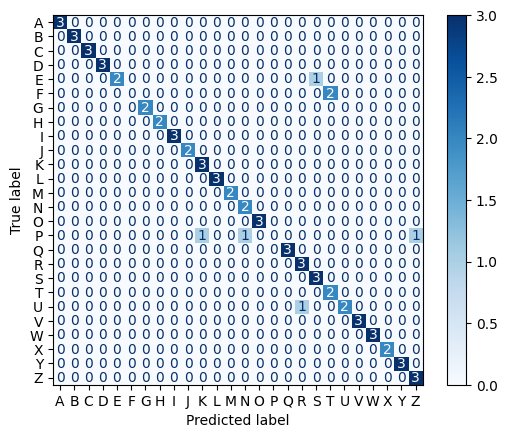

In [86]:
draw_conf_matrix(best_model_1, X_test_1, y_test_detected)

In [87]:
%timeit best_model_1.predict(X_test_1)

17 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Second approch

In [88]:
best_model_2 = test_models_with_grid_search(X_train_2, y_train_detected, X_test_2, y_test_detected)


KNN :
Fitting 5 folds for each of 66 candidates, totalling 330 fits
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best cross-validation score for KNN: 0.2858839972047519

DecisionTree :
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for DecisionTree: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation score for DecisionTree: 0.3498252969951083

SVC :
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters for SVC: {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score for SVC: 0.6618448637316562

RandomForest :
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters for RandomForest: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validat

c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty

Best parameters for LogisticRegression: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score for LogisticRegression: 0.7708595387840671

Best model overall: LogisticRegression(C=10, max_iter=1000)
Best score: 0.7708595387840671
Best test score: 0.9285714285714286
Best parameters: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}


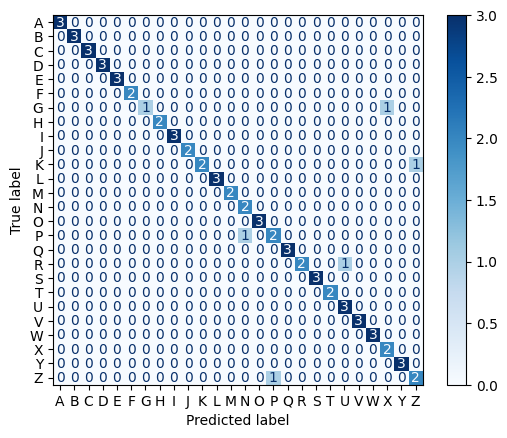

In [89]:
draw_conf_matrix(best_model_2, X_test_2, y_test_detected)

In [90]:
%timeit best_model_2.predict(X_test_2)

75.7 μs ± 5.24 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Combine models

In [91]:
y_pred_1 = best_model_1.predict_proba(X_train_1)
y_pred_2 = best_model_2.predict_proba(X_train_2)
X_train_3 = np.concatenate((y_pred_1, y_pred_2), axis=1)

y_pred_1_test = best_model_1.predict_proba(X_test_1)
y_pred_2_test = best_model_2.predict_proba(X_test_2)
X_test_3 = np.concatenate((y_pred_1_test, y_pred_2_test), axis=1)

In [92]:
best_model_3 = test_models_with_grid_search(X_train_3, y_train_detected, X_test_3, y_test_detected)


KNN :
Fitting 5 folds for each of 66 candidates, totalling 330 fits
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validation score for KNN: 1.0

DecisionTree :
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for DecisionTree: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation score for DecisionTree: 0.992522711390636

SVC :
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters for SVC: {'C': 0.1, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score for SVC: 1.0

RandomForest :
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters for RandomForest: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score for RandomForest: 1.0

Lo

c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty

Best parameters for LogisticRegression: {'C': 0.01, 'class_weight': None, 'penalty': None, 'solver': 'lbfgs'}
Best cross-validation score for LogisticRegression: 1.0

Best model overall: KNeighborsClassifier(metric='euclidean', n_neighbors=1)
Best score: 1.0
Best test score: 0.9285714285714286
Best parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}


c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\courn\Desktop\Projet ML\LSF-Alphabet-Subtitles\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


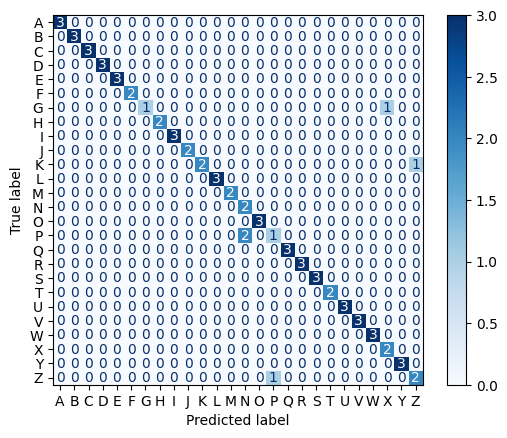

In [93]:
draw_conf_matrix(best_model_3, X_test_3, y_test_detected)

In [94]:
%timeit best_model_3.predict(X_test_3)

19.1 ms ± 791 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Save models

In [95]:
joblib.dump(scaler_1, "scaler_1.pkl", compress=0)
joblib.dump(scaler_2, "scaler_2.pkl", compress=0)
joblib.dump(best_model_1, "best_model_1.pkl", compress=0)
joblib.dump(best_model_2, "best_model_2.pkl", compress=0)
joblib.dump(best_model_3, 'best_model_3.pkl', compress=0)

['best_model_3.pkl']

# Test pipeline

In [96]:
def pipeline_predict(img):
    detection = detector.detect(mp.Image(image_format=mp.ImageFormat.SRGB, data=img))
    if len(detection.handedness) == 0:
      return None

    if detection.handedness[0][0].category_name == "Left":
      for j in range(0, len(detection.hand_landmarks[0])):
        detection.hand_landmarks[0][j].x = 1 - detection.hand_landmarks[0][j].x

    preprocessed = preprocess(detection)

    data_model_1 = scaler_1.transform([preprocessed])
    y_pred_1 = best_model_1.predict_proba(data_model_1)
    entropy_1 = -np.sum(np.clip(y_pred_1[0], 1e-10, 1) * np.log(np.clip(y_pred_1[0], 1e-10, 1))) / math.log(len(y_pred_1[0]))
    if entropy_1 > 0.8:
       return None
    
    data_model_2 = scaler_2.transform([np.array([[lm.x, lm.y, lm.z] for lm in detection.hand_landmarks[0]]).flatten()])
    y_pred_2 = best_model_2.predict_proba(data_model_2)
    entropy_2 = -np.sum(np.clip(y_pred_2[0], 1e-10, 1) * np.log(np.clip(y_pred_2[0], 1e-10, 1))) / math.log(len(y_pred_2[0]))
    if  entropy_2 > 0.9:
       return None

    data_model_3 = np.concatenate((y_pred_1, y_pred_2), axis=1)
    return best_model_3.predict(data_model_3)[0]

In [97]:
img_path = random.choice(test)
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
pred = pipeline_predict(img)

print("Prediction :", chr(65 + pred), ", Réalité :", img_path[-5], ", Hauteur de l'image :", img.shape[0], ", Largeur de l'image :", img.shape[1])

%timeit pipeline_predict(img)

Prediction : Y , Réalité : Y , Hauteur de l'image : 960 , Largeur de l'image : 1440
67.1 ms ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [98]:
# Compute average speed by pixels
times, pixels = [], []
for img_path in train + test:
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  time_start = time.time()
  pred = pipeline_predict(img)
  time_end = time.time()
  times.append((time_end - time_start) * 1000)
  pixels.append(img.shape[0] * img.shape[1])

lr = LinearRegression()
lr.fit(np.array([pixels]).T, np.array(times))
print("time (ms) =", lr.coef_[0], "x Nombre de pixels de l'image +", lr.intercept_)

time (ms) = 1.9945577557693737e-06 x Nombre de pixels de l'image + 63.48569042743929


In [99]:
print("Ainsi pour une webcam en HD (1280 x 720 pixels), prédire une image prendrait environ :", lr.predict([[1280 * 720]])[0], "ms")

Ainsi pour une webcam en HD (1280 x 720 pixels), prédire une image prendrait environ : 65.32387485515635 ms
